<a href="https://colab.research.google.com/github/hritic/Machine-learning/blob/main/cifar10_191cs150_LAB9_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visual Information Processing Lab**

### Datasets and Pre Processing

In [ ]:
import keras
import tensorflow
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10
import numpy as np

In [ ]:
#(xtrain,ytrain),(xtest,ytest)=cifar10.load_data()


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Training parameters
num_classes = 10

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


subtract_pixel_mean = True
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)



(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
from keras import layers
from keras.models import Model
from keras.utils.vis_utils import plot_model

def _after_conv(in_tensor):
    norm = layers.BatchNormalization()(in_tensor)
    return layers.Activation('relu')(norm)

def conv1(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=1)(in_tensor)
    return _after_conv(conv)

def conv1_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=1, strides=2)(in_tensor)
    return _after_conv(conv)

def conv3(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(in_tensor)
    return _after_conv(conv)

def conv3_downsample(in_tensor, filters):
    conv = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(in_tensor)
    return _after_conv(conv)

def resnet_block_wo_bottlneck(in_tensor, filters, downsample=False):
    if downsample:
        conv1_rb = conv3_downsample(in_tensor, filters)
    else:
        conv1_rb = conv3(in_tensor, filters)
    conv2_rb = conv3(conv1_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    result = layers.Add()([conv2_rb, in_tensor])

    return layers.Activation('relu')(result)

def resnet_block_w_bottlneck(in_tensor,
                             filters,
                             downsample=False,
                             change_channels=False):
    if downsample:
        conv1_rb = conv1_downsample(in_tensor, int(filters/4))
    else:
        conv1_rb = conv1(in_tensor, int(filters/4))
    conv2_rb = conv3(conv1_rb, int(filters/4))
    conv3_rb = conv1(conv2_rb, filters)

    if downsample:
        in_tensor = conv1_downsample(in_tensor, filters)
    elif change_channels:
        in_tensor = conv1(in_tensor, filters)
    result = layers.Add()([conv3_rb, in_tensor])

    return result

def _pre_res_blocks(in_tensor):
    conv = layers.Conv2D(64, 7, strides=2, padding='same')(in_tensor)
    conv = _after_conv(conv)
    pool = layers.MaxPool2D(3, 2, padding='same')(conv)
    return pool

def _post_res_blocks(in_tensor, n_classes):
    pool = layers.GlobalAvgPool2D()(in_tensor)
    preds = layers.Dense(n_classes, activation='softmax')(pool)
    return preds

def convx_wo_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_wo_bottlneck(res, filters, downsample_1)
        else:
            res = resnet_block_wo_bottlneck(res, filters)
    return res

def convx_w_bottleneck(in_tensor, filters, n_times, downsample_1=False):
    res = in_tensor
    for i in range(n_times):
        if i == 0:
            res = resnet_block_w_bottlneck(res, filters, downsample_1, not downsample_1)
        else:
            res = resnet_block_w_bottlneck(res, filters)
    return res

def _resnet(in_shape=(224,224,3),
            n_classes=1000,
            opt='sgd',
            convx=[64, 128, 256, 512],
            n_convx=[2, 2, 2, 2],
            convx_fn=convx_wo_bottleneck):
    in_layer = layers.Input(in_shape)

    downsampled = _pre_res_blocks(in_layer)

    conv2x = convx_fn(downsampled, convx[0], n_convx[0])
    conv3x = convx_fn(conv2x, convx[1], n_convx[1], True)
    conv4x = convx_fn(conv3x, convx[2], n_convx[2], True)
    conv5x = convx_fn(conv4x, convx[3], n_convx[3], True)

    preds = _post_res_blocks(conv5x, n_classes)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model

def resnet8(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape, n_classes, opt)

def resnet18(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape, n_classes, opt)

def resnet34(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,n_classes,opt,n_convx=[3, 4, 6, 3])

def resnet50(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,n_classes,opt,[256, 512, 1024, 2048],[3, 4, 6, 3],convx_w_bottleneck)

def resnet101(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,n_classes,opt,[256, 512, 1024, 2048],[3, 4, 23, 3],convx_w_bottleneck)

def resnet152(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    return _resnet(in_shape,n_classes,opt,[256, 512, 1024, 2048],[3, 8, 36, 3],convx_w_bottleneck)

if __name__ == '__main__':
    model = resnet101(in_shape=(32,32,3),n_classes=10, opt='sgd')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

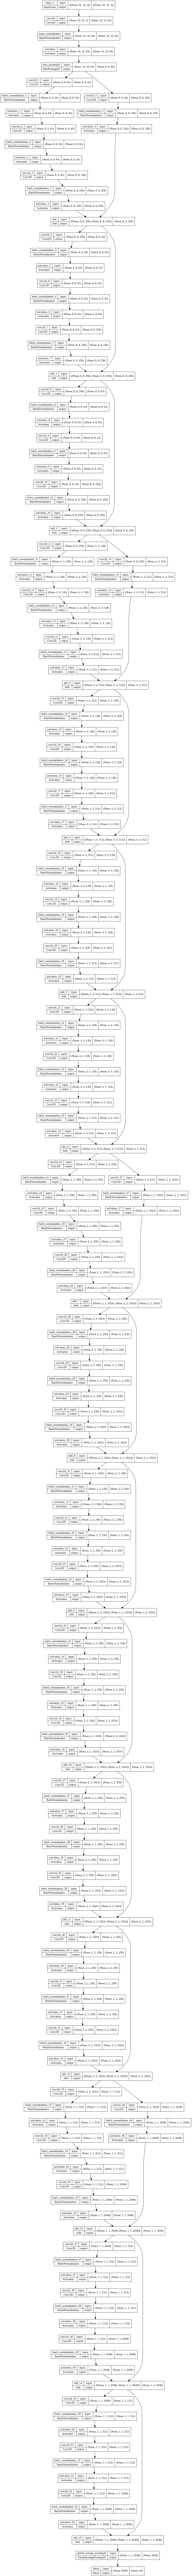

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
model=tensorflow.keras.applications.ResNet101V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=max,
    classes=10
)

print(model.summary())

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.79665 to fit



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


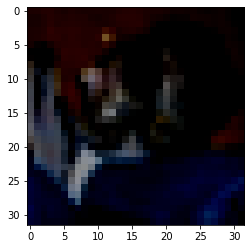

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_test[0])

### Compile and Training the model

In [ ]:
#os.chdir('/content/drive/MyDrive/MLlab pics/Weights/')

#print(os.getcwd())

from keras.callbacks import ModelCheckpoint,CSVLogger
mc = ModelCheckpoint('CNN_Resnet.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
cv = keras.callbacks.CSVLogger('CNN_resnet.csv', separator=',', append=False)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=['accuracy'])
history=model.fit(x_train, y_train, validation_split=(0.2), batch_size=256, callbacks= [mc,cv],epochs=10, verbose=1)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 1.7830 - accuracy: 0.3723
Epoch 1: val_loss improved from inf to 3.48348, saving model to CNN_Resnet.h5
157/157 [==============================] - 149s 632ms/step - loss: 1.7830 - accuracy: 0.3723 - val_loss: 3.4835 - val_accuracy: 0.1005
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 1.4587 - accuracy: 0.4904
Epoch 2: val_loss improved from 3.48348 to 2.28056, saving model to CNN_Resnet.h5
157/157 [==============================] - 96s 613ms/step - loss: 1.4587 - accuracy: 0.4904 - val_loss: 2.2806 - val_accuracy: 0.2516
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 1.3273 - accuracy: 0.5440
Epoch 3: val_loss improved from 2.28056 to 1.91201, saving model to CNN_Resnet.h5
157/157 [==============================] - 95s 604ms/step - loss: 1.3273 - accuracy: 0.5440 - val_loss: 1.9120 - val_accuracy: 0.4383
Epoch 4/10
157/157 [==============================] - ETA: 0s - los

### Evaluate

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 16s 48ms/step - loss: 1.4773 - accuracy: 0.5925


[1.4772999286651611, 0.5924999713897705]

### Loss and Accuracy Curves

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

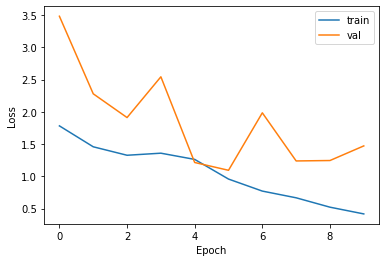

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

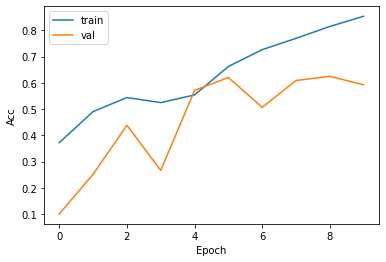

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.68      0.63      0.65      1000
     class 1       0.72      0.73      0.73      1000
     class 2       0.34      0.68      0.45      1000
     class 3       0.49      0.21      0.30      1000
     class 4       0.63      0.49      0.55      1000
     class 5       0.47      0.54      0.50      1000
     class 6       0.68      0.62      0.65      1000
     class 7       0.72      0.68      0.70      1000
     class 8       0.91      0.57      0.70      1000
     class 9       0.64      0.76      0.70      1000

    accuracy                           0.59     10000
   macro avg       0.63      0.59      0.59     10000
weighted avg       0.63      0.59      0.59     10000



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[631  37 183  15  18  16  15   4  24  57]
 [ 18 735  71   6   2   8   7   2   5 146]
 [ 38   7 680  15  82  95  40  25   2  16]
 [ 17  19 272 215  53 242  91  51   6  34]
 [ 16  13 175  39 490  92  89  56   8  22]
 [ 13  11 167  78  36 537  28 108   7  15]
 [  2  11 244  14  30  55 621   7   0  16]
 [ 17  11  89  32  54  69  13 679   2  34]
 [141  76  67  16   7  14   9   7 574  89]
 [ 35  98  51   6   1  26   5   9   6 763]]


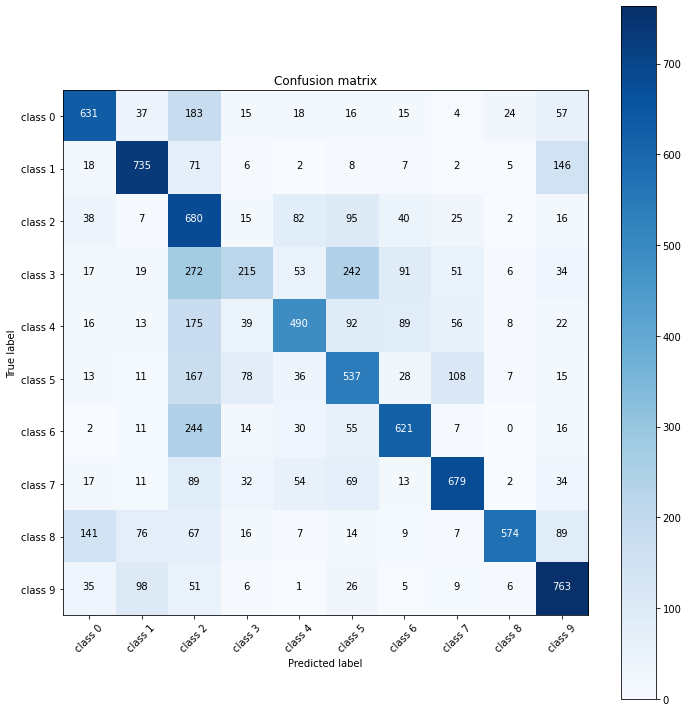

In [ ]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.show()

## Visualization

In [ ]:
for layer in model.layers:
  print(layer)